In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [50]:
import numpy as np
import pandas as pd
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt

from natsort import natsort_keygen

import statsmodels.api as sm
import scipy as sp

import os
import json
import psycopg2
from tqdm.notebook import tqdm, trange
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

# Globals

A few general variable about where to find stuff. Adapt to your own needs.

In [6]:
datadir = '.'
plotdir = 'plots'

# Input
tally_mut = os.path.join(datadir, 'tallymut_line_snv.tsv')
viollier_data = os.path.join(datadir, 'viollier_data.csv')
data_per_day_and_canton = os.path.join(datadir, 'data_per_day_and_canton2.csv')

# Output
update_data_file = os.path.join(datadir, 'ww_update_data.json')

# Load data

## Load WWTP sequencing data

In [7]:
df = pd.read_csv(tally_mut, sep='\t', parse_dates=['date'])

df['mutation'] = df['pos'].astype(str) + df['base']

df.head()

sample               batch   pos       date  plantcode  \
0  05_2021_02_02  20210416_HYTGGDRXX   733 2021-02-02        5.0   
1  05_2021_02_02  20210416_HYTGGDRXX   913 2021-02-02        5.0   
2  05_2021_02_02  20210416_HYTGGDRXX  1059 2021-02-02        5.0   
3  05_2021_02_02  20210416_HYTGGDRXX  2749 2021-02-02        5.0   
4  05_2021_02_02  20210416_HYTGGDRXX  3267 2021-02-02        5.0   

      plantname    gene base  cov  var  frac     BR   EU     UK   ZA mutation  
0  Bioggio (TI)  ORF1ab    C    0    0   NaN  extra  NaN    NaN  NaN     733C  
1  Bioggio (TI)  ORF1ab    T    0    0   NaN    NaN  NaN  extra  NaN     913T  
2  Bioggio (TI)  ORF1ab    T    0    0   NaN    NaN  NaN    NaN  mut    1059T  
3  Bioggio (TI)  ORF1ab    T    0    0   NaN  extra  NaN    NaN  NaN    2749T  
4  Bioggio (TI)  ORF1ab    T    0    0   NaN    NaN  NaN    mut  NaN    3267T

In [8]:
df_wide = (
    df[(~df['plantname'].isna()) & (df['date'] >= '2020-12-08') & (df['base'] != '-') & (df['UK'] == "mut")]
    .pivot(index=['plantname', 'date', 'batch'], columns=['mutation'], values='frac')
    .sort_index(axis=1, key=natsort_keygen())
)

df_wide.head()

mutation                                          3267T     5388A     6954C  \
plantname       date       batch                                              
Altenrhein (SG) 2021-02-01 20210416_HYTGGDRXX  0.000056  1.000000  1.000000   
                2021-02-02 20210416_HYTGGDRXX  0.000038  0.000000  0.000000   
                2021-02-03 20210416_HYTGGDRXX  0.172658  0.122338  0.240476   
                2021-02-04 20210416_HYTGGDRXX  0.747479  0.000000  0.400000   
                2021-02-05 20210416_HYTGGDRXX  0.329857  0.784046  0.232604   

mutation                                         23063T    23271A    23604A  \
plantname       date       batch                                              
Altenrhein (SG) 2021-02-01 20210416_HYTGGDRXX  0.000000  0.000575  0.000288   
                2021-02-02 20210416_HYTGGDRXX  0.000000  0.000623  0.000185   
                2021-02-03 20210416_HYTGGDRXX  0.078014  0.115444  0.152003   
                2021-02-04 20210416_HYTGGDRXX  0.001225  0.000644  0.000157   
                2021-02-05 20210416_HYTGGDRXX  0.418738  0.206090  0.334837   

mutation                                         23709T    24506G    24914C  \
plantname       date       batch                                              
Altenrhein (SG) 2021-02-01 20210416_HYTGGDRXX  0.000000  0.000000  0.196052   
                2021-02-02 20210416_HYTGGDRXX  0.000071  0.496722  0.395383   
                2021-02-03 20210416_HYTGGDRXX  0.171960  0.328849  0.184255   
                2021-02-04 20210416_HYTGGDRXX  0.000000  0.561218  0.000273   
                2021-02-05 20210416_HYTGGDRXX  0.388153  0.000103  0.253923   

mutation                                         27972T    28048T    28111G  \
plantname       date       batch                                              
Altenrhein (SG) 2021-02-01 20210416_HYTGGDRXX  0.339560  0.339346  0.082079   
                2021-02-02 20210416_HYTGGDRXX  0.357181  0.357605  0.044219   
                2021-02-03 20210416_HYTGGDRXX  0.090484  0.091667  0.185049   
                2021-02-04 20210416_HYTGGDRXX  0.322816  0.323560  0.120502   
                2021-02-05 20210416_HYTGGDRXX  0.113395  0.112806  0.032225   

mutation                                         28280C    28281T    28282A  \
plantname       date       batch                                              
Altenrhein (SG) 2021-02-01 20210416_HYTGGDRXX  0.000053  0.000626  0.000154   
                2021-02-02 20210416_HYTGGDRXX  0.003693  0.004151  0.003825   
                2021-02-03 20210416_HYTGGDRXX  0.214788  0.215199  0.214697   
                2021-02-04 20210416_HYTGGDRXX  0.064394  0.064793  0.064374   
                2021-02-05 20210416_HYTGGDRXX  0.003391  0.003774  0.003523   

mutation                                         28977T  
plantname       date       batch                         
Altenrhein (SG) 2021-02-01 20210416_HYTGGDRXX  0.348775  
                2021-02-02 20210416_HYTGGDRXX  0.295432  
                2021-02-03 20210416_HYTGGDRXX  0.191049  
                2021-02-04 20210416_HYTGGDRXX  0.371522  
                2021-02-05 20210416_HYTGGDRXX  0.251344

In [9]:
df_wide_cov = (
    df[(~df['plantname'].isna()) & (df['date'] >= '2020-12-08') & (df['base'] != '-') & (df['UK'] == "mut")]
    .pivot(index=['plantname', 'date', 'batch'], columns=['mutation'], values='cov')
    .sort_index(axis=1, key=natsort_keygen())
)

df_wide_counts = (
    df[(~df['plantname'].isna()) & (df['date'] >= '2020-12-08') & (df['base'] != '-') & (df['UK'] == "mut")]
    .pivot(index=['plantname', 'date', 'batch'], columns=['mutation'], values='var')
    .sort_index(axis=1, key=natsort_keygen())
)

In [10]:
df.plantname.unique()

array(['Bioggio (TI)', 'Zürich (ZH)', 'Lausanne (VD)', 'Chur (GR)',
       'Altenrhein (SG)', nan, 'Laupen (BE)', 'Ski-resort',
       'water negative', 'Locarno (TI)', 'Lenzburg (AG)', 'Bern (BE)',
       'Basel (BS)', 'Geneva (GE)', 'Luzern (LU)', 'Schaffhausen (SH)',
       'Freienbach (SZ)', 'Fribourg (FR)', 'Ergolz (BL)'], dtype=object)

In [11]:
df[df.plantname == "Bioggio (TI)"]

sample               batch    pos       date  plantcode  \
0         05_2021_02_02  20210416_HYTGGDRXX    733 2021-02-02        5.0   
1         05_2021_02_02  20210416_HYTGGDRXX    913 2021-02-02        5.0   
2         05_2021_02_02  20210416_HYTGGDRXX   1059 2021-02-02        5.0   
3         05_2021_02_02  20210416_HYTGGDRXX   2749 2021-02-02        5.0   
4         05_2021_02_02  20210416_HYTGGDRXX   3267 2021-02-02        5.0   
...                 ...                 ...    ...        ...        ...   
43909  G1_05_2021_05_11      20210520_JFTLP  28512 2021-05-11        5.0   
43910  G1_05_2021_05_11      20210520_JFTLP  28877 2021-05-11        5.0   
43911  G1_05_2021_05_11      20210520_JFTLP  28878 2021-05-11        5.0   
43912  G1_05_2021_05_11      20210520_JFTLP  28887 2021-05-11        5.0   
43913  G1_05_2021_05_11      20210520_JFTLP  28977 2021-05-11        5.0   

          plantname    gene base   cov  var  frac      BR   EU     UK   ZA  \
0      Bioggio (TI)  ORF1ab    C     0    0   NaN   extra  NaN    NaN  NaN   
1      Bioggio (TI)  ORF1ab    T     0    0   NaN     NaN  NaN  extra  NaN   
2      Bioggio (TI)  ORF1ab    T     0    0   NaN     NaN  NaN    NaN  mut   
3      Bioggio (TI)  ORF1ab    T     0    0   NaN   extra  NaN    NaN  NaN   
4      Bioggio (TI)  ORF1ab    T     0    0   NaN     NaN  NaN    mut  NaN   
...             ...     ...  ...   ...  ...   ...     ...  ...    ...  ...   
43909  Bioggio (TI)       N    G  2106    0   0.0     mut  NaN    NaN  NaN   
43910  Bioggio (TI)       N    T   312    0   0.0  shared  NaN    NaN  NaN   
43911  Bioggio (TI)       N    C   311    0   0.0  shared  NaN    NaN  NaN   
43912  Bioggio (TI)       N    T   293    0   0.0     NaN  NaN    NaN  mut   
43913  Bioggio (TI)       N    T   156  156   1.0     NaN  NaN    mut  NaN   

      mutation  
0         733C  
1         913T  
2        1059T  
3        2749T  
4        3267T  
...        ...  
43909   28512G  
43910   28877T  
43911   28878C  
43912   28887T  
43913   28977T  

[7644 rows x 16 columns]

In [12]:
df_wide.loc["Ski-resort"].index.get_level_values(0).unique()

DatetimeIndex(['2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27',
               '2020-12-28', '2020-12-29'],
              dtype='datetime64[ns]', name='date', freq=None)

In [13]:
df_wide.index.get_level_values(0).unique()

Index(['Altenrhein (SG)', 'Bioggio (TI)', 'Chur (GR)', 'Laupen (BE)',
       'Lausanne (VD)', 'Ski-resort', 'Zürich (ZH)', 'water negative'],
      dtype='object', name='plantname')

<AxesSubplot:xlabel='date-batch', ylabel='mutation'>

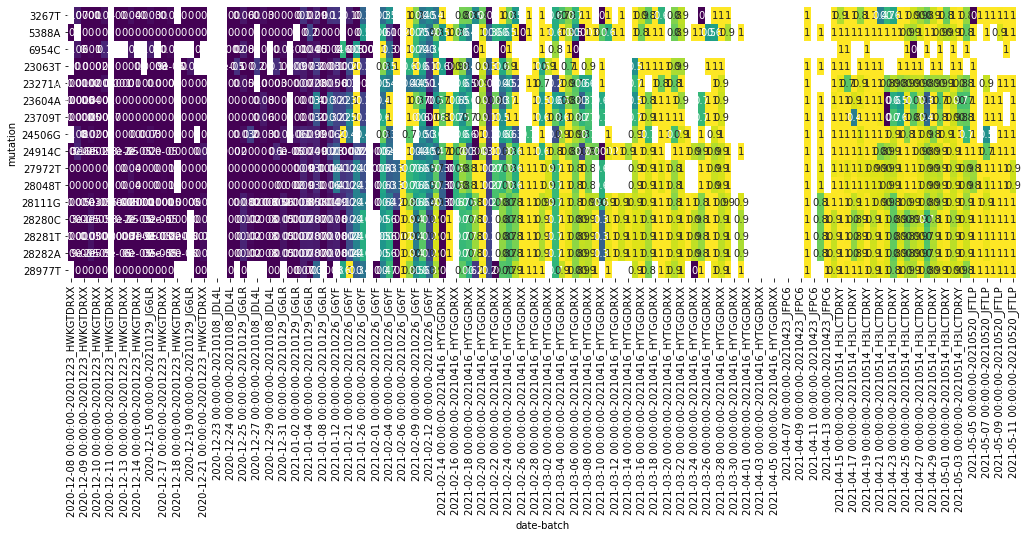

In [15]:
plt.figure(figsize=(17,5))
sns.heatmap(
    data=df_wide.loc["Lausanne (VD)"].T.applymap(lambda x: np.nan if pd.isna(x) else x),
    annot=df_wide.loc["Lausanne (VD)"].T,
    fmt='.1g',
    square=False, cbar=False,
    cmap=sns.color_palette("viridis", as_cmap=True)
)

## Load national viollier data

In [19]:
viollier = pd.read_csv(viollier_data)
viollier.index = pd.to_datetime(viollier["year"].astype(str), format='%Y') +\
    pd.to_timedelta(((viollier["week"]-1).mul(7)+3-7).astype(str) + ' days')
viollier["frac_b117"] = viollier["b117"] / viollier["n"]
viollier["p_pseudo"] = (viollier["b117"] + 1) / viollier["n"]
viollier["error"] = 1.96*np.sqrt(viollier["p_pseudo"]*(1-viollier["p_pseudo"])/viollier["n"])

## Load cantonal viollier data and aggregate by week

In [20]:
viollier2 = pd.read_csv(data_per_day_and_canton)
viollier2["date"] = pd.DatetimeIndex(viollier2["date"])
viollier2["week"] = viollier2.date.dt.strftime('%W')
viollier2["year"] = viollier2.date.dt.strftime('%Y')
viollier2["date_week"] = pd.to_datetime(viollier2["year"].astype(str), format='%Y') +\
    pd.to_timedelta(((viollier2["week"].astype("int")-1).mul(7)+3-7).astype(str) + ' days')

viollier2_sum = viollier2.groupby(["date_week", "canton"], as_index=False).agg("sum")
viollier2_sum["frac_b117"] = viollier2_sum["b117"] / viollier2_sum["sequenced"]
viollier2_sum["p_pseudo"] = (viollier2_sum["b117"] + 1) / (viollier2_sum["sequenced"] + 2)
viollier2_sum["error"] = 1.96*np.sqrt(viollier2_sum["p_pseudo"]*(1-viollier2_sum["p_pseudo"])/(viollier2_sum["sequenced"]+2))

# Do resampling confint for lowess

In [53]:
def resample_fn(x, nsamples):
    return np.array([np.mean(np.random.choice(x[np.isnan(x)==False],
                                              x[np.isnan(x)==False].shape[0],
                                              replace=True)) \
            for i in range(nsamples)])

lowess = sm.nonparametric.lowess

In [55]:
VDdf = df_wide.loc['Lausanne (VD)'].dropna(axis=1, how='all').T  # .loc[28111:28111]
VDyres = VDdf.T.apply(lambda x: resample_fn(x, 1000), 1)

VDyres2 = pd.DataFrame(np.array([i for i in VDyres.values]))
VDyres2.index = VDyres.index

VDagg1 = VDyres2.groupby("date").agg("mean").asfreq('D')
VDagg2 = VDagg1.apply(lambda x: x.rolling(7, min_periods=1).mean(), 0)
VDagg3 = VDagg1.apply(lambda x: lowess(x, np.arange(x.shape[0]).astype("float64"),
                                       xvals = np.arange(x.shape[0]).astype("float64"),
                                       frac= 20/VDyres2.shape[0], it=0), 0)



/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/p

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

In [23]:
ZHyres2.shape[0]

NameError: name 'ZHyres2' is not defined

In [24]:
ZHdf = df_wide.loc['Zürich (ZH)'].dropna(axis=1, how='all').T  # .loc[28111:28111]
ZHyres = ZHdf.T.apply(lambda x: resample_fn(x, 1000), 1)

ZHyres2 = pd.DataFrame(np.array([i for i in ZHyres.values]))
ZHyres2.index = ZHyres.index

ZHagg1 = ZHyres2.groupby("date").agg("mean").asfreq('D')
ZHagg2 = ZHagg1.apply(lambda x: x.rolling(7, min_periods=1).mean(), 0)
ZHagg3 = ZHagg1.apply(lambda x: lowess(x, np.arange(x.shape[0]).astype("float64"),
                                       xvals = np.arange(x.shape[0]).astype("float64"),
                                       frac= 20/ZHyres2.shape[0], it=0), 0)


/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/p

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/dryak/miniconda3/envs/brexit-bio1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dryak/miniconda3/envs/brexit-bio1/lib/python

In [25]:
viollier2["date"] = pd.to_datetime(viollier2["date"])

viollierZH = viollier2[viollier2["canton"]=="ZH"]
viollierZH = viollierZH.sort_values("date")
viollierZH["frac"] = viollierZH["b117"] / viollierZH["sequenced"]
viollierZH = viollierZH[(viollierZH["date"] >= np.datetime64("2020-12-08")) & (viollierZH["date"] <= np.datetime64("2021-02-11"))]

lowess = sm.nonparametric.lowess
viollierZH["loess"] = lowess(endog=viollierZH["frac"],
                             exog=np.arange(viollierZH.shape[0]).astype("float64"),
                             xvals=np.arange(viollierZH.shape[0]).astype("float64"),
                             frac= 2./3, it=3)

viollierVD = viollier2[viollier2["canton"]=="VD"]
viollierVD = viollierVD.sort_values("date")
viollierVD["frac"] = viollierVD["b117"] / viollierVD["sequenced"]
viollierVD = viollierVD[(viollierVD["date"] >= np.datetime64("2020-12-08")) & (viollierVD["date"] <= np.datetime64("2021-02-11"))]

lowess = sm.nonparametric.lowess
viollierVD["loess"] = lowess(endog=viollierVD["frac"],
                             exog=np.arange(viollierVD.shape[0]).astype("float64"),
                             xvals=np.arange(viollierVD.shape[0]).astype("float64"),
                             frac= 2./3, it=3)


In [26]:
viollier2["date"] = pd.to_datetime(viollier2["date"])

viollierZH = viollier2[viollier2["canton"]=="ZH"]
viollierZH = viollierZH.sort_values("date")
viollierZH["frac"] = viollierZH["b117"] / viollierZH["sequenced"]
viollierZH = viollierZH[(viollierZH["date"] >= np.datetime64("2020-12-08")) & (viollierZH["date"] <= np.datetime64("2021-02-11"))]

lowess = sm.nonparametric.lowess
viollierZH["loess"] = lowess(endog=viollierZH["frac"],
                             exog=np.arange(viollierZH.shape[0]).astype("float64"),
                             xvals=np.arange(viollierZH.shape[0]).astype("float64"),
                             frac= 1./3, it=3)

viollierVD = viollier2[viollier2["canton"]=="VD"]
viollierVD = viollierVD.sort_values("date")
viollierVD["frac"] = viollierVD["b117"] / viollierVD["sequenced"]
viollierVD = viollierVD[(viollierVD["date"] >= np.datetime64("2020-12-08")) & (viollierVD["date"] <= np.datetime64("2021-02-13"))]

lowess = sm.nonparametric.lowess
viollierVD["loess"] = lowess(endog=viollierVD["frac"],
                             exog=np.arange(viollierVD.shape[0]).astype("float64"),
                             xvals=np.arange(viollierVD.shape[0]).astype("float64"),
                             frac= 1./3, it=3)


## Resample clinical loess

# Remake clinical loess by resampling cases

In [27]:
viollierZH2 = viollierZH[(viollierZH["date"] >= np.datetime64("2020-12-08")) & (viollierZH["date"] <= np.datetime64("2021-02-11"))]
viollierVD2 = viollierVD[(viollierVD["date"] >= np.datetime64("2020-12-08")) & (viollierVD["date"] <= np.datetime64("2021-02-13"))]

### Create extended df with one row per case

In [28]:
ZH1hotdfs = []
for d in viollierZH2["date"]:
    for i in range(viollierZH2[viollierZH2["date"]==d]["b117"].values[0]):
        ZH1hotdfs.append(pd.DataFrame({"date":d, "wt":0, "b117":1}, index=[0]))
    for i in range(viollierZH2[viollierZH2["date"]==d]["sequenced"].values[0] - viollierZH2[viollierZH2["date"]==d]["b117"].values[0]):
        ZH1hotdfs.append(pd.DataFrame({"date":d, "wt":1, "b117":0}, index=[0]))
viollierZH2_1hot = pd.concat(ZH1hotdfs).reset_index(drop=True)

In [29]:
VD1hotdfs = []
for d in viollierVD2["date"]:
    for i in range(viollierVD2[viollierVD2["date"]==d]["b117"].values[0]):
        VD1hotdfs.append(pd.DataFrame({"date":d, "wt":0, "b117":1}, index=[0]))
    for i in range(viollierVD2[viollierVD2["date"]==d]["sequenced"].values[0] - viollierVD2[viollierVD2["date"]==d]["b117"].values[0]):
        VD1hotdfs.append(pd.DataFrame({"date":d, "wt":1, "b117":0}, index=[0]))
viollierVD2_1hot = pd.concat(VD1hotdfs).reset_index(drop=True)

### resample cases

In [33]:
ZHclinlowess = []
np.random.seed(42)
for i in trange(1000):
    resamp_df = viollierZH2_1hot.iloc[np.random.randint(0, viollierZH2_1hot.shape[0], viollierZH2_1hot.shape[0]),:]
    resamp_df = resamp_df.groupby("date").agg("sum").reindex(viollierZH2["date"])
    resamp_df["freq"] = resamp_df["b117"] / (resamp_df["b117"] + resamp_df["wt"])
    ZHclinlowess.append(lowess(resamp_df["freq"],
                               np.arange(resamp_df.shape[0]).astype("float64"),
                               xvals=np.arange(resamp_df.shape[0]).astype("float64"), frac=1./3))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
VDclinlowess = []
np.random.seed(42)
for i in trange(1000):
    resamp_df = viollierVD2_1hot.iloc[np.random.randint(0, viollierVD2_1hot.shape[0], viollierVD2_1hot.shape[0]),:]
    resamp_df = resamp_df.groupby("date").agg("sum").reindex(viollierVD2["date"])
    resamp_df["freq"] = resamp_df["b117"] / (resamp_df["b117"] + resamp_df["wt"])
    VDclinlowess.append(lowess(resamp_df["freq"],
                               np.arange(resamp_df.shape[0]).astype("float64"),
                               xvals=np.arange(resamp_df.shape[0]).astype("float64"), frac=1./3))

  0%|          | 0/1000 [00:00<?, ?it/s]

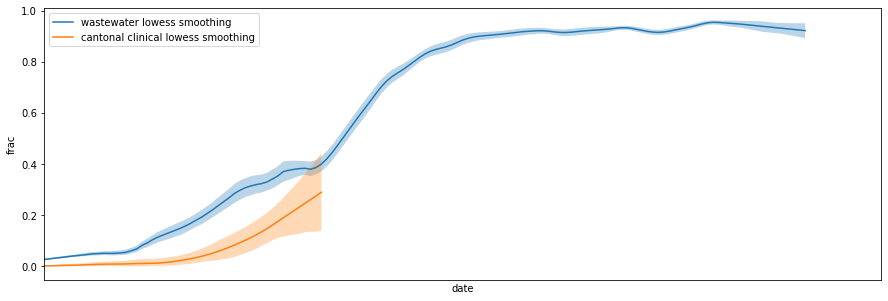

In [35]:
# import matplotlib.gridspec as gridspec
ZHdf = df_wide.loc['Zürich (ZH)'].dropna(axis=1, how='all').T  # .loc[28111:28111]
ZHdf = ZHdf.T.groupby("date").agg("mean").asfreq('D').T

fig, ax = plt.subplots(nrows=1, figsize=(15, 5), sharex=False)
ax = [ax]

xvals = ZHdf.T.index#.astype("str")
yvals = ZHdf.apply(np.mean, 0)

### 

sns.lineplot(x=xvals, y=ZHagg3.apply(np.mean, 1), ax=ax[0], label="wastewater lowess smoothing")
ax[0].fill_between(xvals,
                     ZHagg3.apply(lambda x: np.percentile(x, 5), 1).interpolate(),
                     ZHagg3.apply(lambda x: np.percentile(x, 95), 1).interpolate(),
                     alpha=.3)

sns.lineplot(x=xvals[:66], y=np.nanmean(np.array(ZHclinlowess), axis=0),
             ax=ax[0], label="cantonal clinical lowess smoothing")
ax[0].fill_between(xvals[:66],
                     np.nanpercentile(np.array(ZHclinlowess), q=2.5, axis=0),
                     np.nanpercentile(np.array(ZHclinlowess), q=97.5, axis=0),
                     alpha=.3)

sns.barplot(x=xvals[:66], y=viollierZH[viollierZH["date"].isin(xvals)]["frac"],
            ax=ax[0], label="cantonal clinical empirical frequencies", color="orange", alpha=0.5)


# ax[0].set_ylim((0,0.125))
ax[0].set_xlim((np.datetime64("2020-12-22"), np.datetime64("2021-05-25")))
# ax[0].set_ylabel("frac. B.1.1.7")
# ax[0].legend(loc="upper left")
# ax[0].set_title('Zurich: relative B.1.1.7 prevalence estimates from wastewater samples\n compared to relative prevalence estimates from cantonal clinical samples')
# ax[0].set_xticks(["2020-12-15", "2021-01-01", "2021-01-15", "2021-02-01", "2021-02-15"])

# ax[0].set_xticklabels(labels=xvals, rotation=90, ha='center')

# plt.savefig("plots/ZurPlot2.pdf", bbox_inches='tight')
plt.show()


In [36]:
VDdf.T.index

MultiIndex([('2020-12-08', '20201223_HWKGTDRXX'),
            ('2020-12-08',     '20210129_JG6LR'),
            ('2020-12-09', '20201223_HWKGTDRXX'),
            ('2020-12-09',     '20210129_JG6LR'),
            ('2020-12-10', '20201223_HWKGTDRXX'),
            ('2020-12-10',     '20210129_JG6LR'),
            ('2020-12-11', '20201223_HWKGTDRXX'),
            ('2020-12-12', '20201223_HWKGTDRXX'),
            ('2020-12-13', '20201223_HWKGTDRXX'),
            ('2020-12-13',     '20210129_JG6LR'),
            ...
            ('2021-05-02', '20210514_H3LCTDRXY'),
            ('2021-05-03', '20210514_H3LCTDRXY'),
            ('2021-05-04', '20210514_H3LCTDRXY'),
            ('2021-05-05',     '20210520_JFTLP'),
            ('2021-05-06',     '20210520_JFTLP'),
            ('2021-05-07',     '20210520_JFTLP'),
            ('2021-05-08',     '20210520_JFTLP'),
            ('2021-05-09',     '20210520_JFTLP'),
            ('2021-05-10',     '20210520_JFTLP'),
            ('2021-05-11',     '20

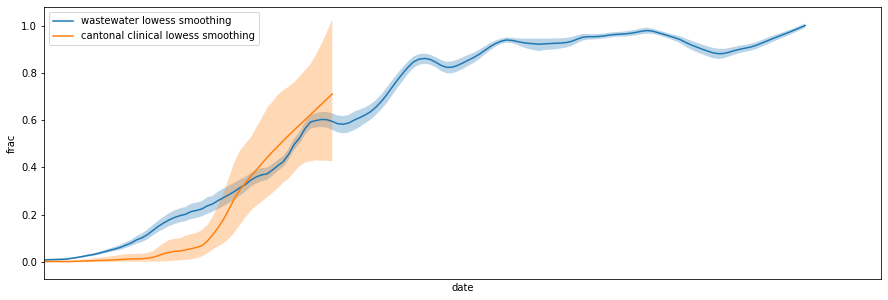

In [37]:
VDdf = df_wide.loc['Lausanne (VD)'].dropna(axis=1, how='all').T  # .loc[28111:28111]
VDdf = VDdf.T.groupby("date").agg("mean").asfreq('D').T

fig, ax = plt.subplots(nrows=1, figsize=(15, 5), sharex=False)
ax = [ax]

xvals = VDdf.T.index#.astype("str")
yvals = VDdf.apply(np.mean, 0)

### 

sns.lineplot(x=xvals, y=VDagg3.apply(np.mean, 1), ax=ax[0], label="wastewater lowess smoothing")
ax[0].fill_between(xvals,
                     VDagg3.apply(lambda x: np.percentile(x, 5), 1).interpolate(),
                     VDagg3.apply(lambda x: np.percentile(x, 95), 1).interpolate(),
                     alpha=.3)

sns.lineplot(x=xvals[0:68], y=np.nanmean(np.array(VDclinlowess), axis=0),
             ax=ax[0], label="cantonal clinical lowess smoothing")
ax[0].fill_between(xvals[0:68],
                     np.nanpercentile(np.array(VDclinlowess), q=2.5, axis=0),
                     np.nanpercentile(np.array(VDclinlowess), q=97.5, axis=0),
                     alpha=.3)

sns.barplot(x=xvals[0:68], y=viollierVD[viollierVD["date"].isin(xvals)]["frac"],
            ax=ax[0], label="cantonal clinical empirical frequencies", color="orange", alpha=0.5)


# ax[0].set_ylim((0,0.125))
# ax[0].set_ylabel("frac. B.1.1.7")
# ax[0].legend(loc="upper left")
# ax[0].set_title('Lausanne: relative B.1.1.7 prevalence estimates from wastewater samples\n compared to relative prevalence estimates from cantonal clinical samples')
# ax[0].set_xticks(["2020-12-15", "2021-01-01", "2021-01-15", "2021-02-01", "2021-02-15"])
ax[0].set_xlim((np.datetime64("2020-12-22"), np.datetime64("2021-05-25")))

# ax[0].set_xticklabels(labels=xvals, rotation=90, ha='center')
# fig.autofmt_xdate()

# plt.savefig("plots/LausPlot2.pdf", bbox_inches='tight')
plt.show()

# Make data for covSPECTRUM

In [38]:
vd_tdf = VDagg3.apply(lambda x: {"proportion":np.mean(x),
                                 "proportionLower":np.percentile(x, 5),
                                 "proportionUpper":np.percentile(x, 95)},
                     axis=1, result_type ='expand')
vd_tdf = vd_tdf.reset_index()
vd_tdf["date"] = vd_tdf["date"].astype("str")

vd_tdf_mat = VDdf.T.melt(ignore_index=False, var_name="nucMutation", value_name="proportion").reset_index()
vd_tdf_mat["date"] = vd_tdf_mat["date"].astype("str")

zh_tdf = ZHagg3.apply(lambda x: {"proportion":np.mean(x),
                                 "proportionLower":np.percentile(x, 5),
                                 "proportionUpper":np.percentile(x, 95)},
                     axis=1, result_type ='expand')
zh_tdf = zh_tdf.reset_index()
zh_tdf["date"] = zh_tdf["date"].astype("str")

zh_tdf_mat = ZHdf.T.melt(ignore_index=False, var_name="nucMutation", value_name="proportion").reset_index()
zh_tdf_mat["date"] = zh_tdf_mat["date"].astype("str")

update_data = {
    "updateDate": "2021-05-26",
    "data": [
        {
            "location": "Lausanne",
            "timeseriesSummary": [dict(vd_tdf.iloc[i,]) for i in range(vd_tdf.shape[0])], 
            "mutationOccurrences": [dict(vd_tdf_mat.iloc[i,]) for i in range(vd_tdf_mat.shape[0])]
        },
        {
            "location": "Zürich",
            "timeseriesSummary": [dict(zh_tdf.iloc[i,]) for i in range(zh_tdf.shape[0])], 
            "mutationOccurrences": [dict(zh_tdf_mat.iloc[i,]) for i in range(zh_tdf_mat.shape[0])]
            
        }
    ]
}

import json
with open('ww_update_data.json', 'w') as file:
     file.write(json.dumps(update_data))